In [2]:
### Config
IMAGE_PATH = "./dataset/"
MAX_IMAGES_TO_LOAD = 1500
DENSE_BLOCK_SIZE = 25

In [3]:
import tensorflow.keras.layers
import tensorflow.keras.models
import matplotlib.pyplot as plt
import tensorflow.keras.datasets
import tensorflow.keras.optimizers 
from os import walk
import numpy
from timeit import default_timer as timer
from keras.preprocessing.image import load_img 
import warnings 
from keras.preprocessing.image import img_to_array 
from keras.preprocessing.image import array_to_img 

Using TensorFlow backend.


In [4]:
def get_size(np):
    return np.size * np.itemsize

In [5]:
### Loading manga images in the memory
images = []
for (dirpath, dirnames, filenames) in walk(IMAGE_PATH):
    images.extend(filenames)
    break

mangas = []
for i,img in enumerate(images):
    img_path = f"{IMAGE_PATH}{img}"
    img_data = load_img(img_path)
    mangas.append(img_to_array(img_data))
    if i > MAX_IMAGES_TO_LOAD:
        break

In [6]:
### Get max length of the image
max_linear_size = -1
original_shape = None
for m in mangas:
    h, w, d = m.shape
    m_length = h * w * d
    if m_length > max_linear_size:
        original_shape = m.shape
        max_linear_size = m_length

In [8]:
print(original_shape)
print(max_linear_size)

(1637, 690, 3)
3388590


In [46]:
images = None

for i, m in enumerate(mangas):
    temp = m.reshape(-1)

    if temp.shape[0] < max_linear_size:
        padded_array = numpy.zeros((max_linear_size))
        padded_array[:temp.shape[0]] = temp

        if i == 0:
            images = padded_array
        else:
            images = numpy.vstack((images, padded_array))

print(images.shape)

(5, 3388590)


In [54]:
x = tensorflow.keras.layers.Input(shape=(max_linear_size), name="encoder_input")

encoder_dense_layer1 = tensorflow.keras.layers.Dense(units=30, name="encoder_dense_1")(x)
encoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="encoder_leakyrelu_1")(encoder_dense_layer1)

encoder_dense_layer2 = tensorflow.keras.layers.Dense(units=DENSE_BLOCK_SIZE, name="encoder_dense_2")(encoder_activ_layer1)
encoder_output = tensorflow.keras.layers.LeakyReLU(name="encoder_output")(encoder_dense_layer2)

encoder = tensorflow.keras.models.Model(x, encoder_output, name="encoder_model")

In [55]:
decoder_input = tensorflow.keras.layers.Input(shape=(DENSE_BLOCK_SIZE), name="decoder_input")

decoder_dense_layer1 = tensorflow.keras.layers.Dense(units=30, name="decoder_dense_1")(decoder_input)
decoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_1")(decoder_dense_layer1)

decoder_dense_layer2 = tensorflow.keras.layers.Dense(units=max_linear_size , name="decoder_dense_2")(decoder_activ_layer1)
decoder_output = tensorflow.keras.layers.LeakyReLU(name="decoder_output")(decoder_dense_layer2)

decoder = tensorflow.keras.models.Model(decoder_input, decoder_output, name="decoder_model")

In [56]:
ae_input = tensorflow.keras.layers.Input(shape=(max_linear_size), name="AE_input")
ae_encoder_output = encoder(ae_input)
ae_decoder_output = decoder(ae_encoder_output)

ae = tensorflow.keras.models.Model(ae_input, ae_decoder_output, name="AE")
ae.compile(loss="mse", optimizer=tensorflow.keras.optimizers.Adam(lr=0.0005))

In [52]:
numpy.random.shuffle(images)
x_train, x_test = images[:80,:], images[80:,:]

In [57]:
ae.fit(x_train, x_train, epochs=120,batch_size=256, shuffle=True, validation_data=(x_test, x_test))

Train on 5 samples
Epoch 1/120


ResourceExhaustedError: OOM when allocating tensor with shape[30,3388590] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training_2/Adam/Adam/update_decoder_dense_2_2/kernel/ResourceApplyAdam}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [10]:
encoded_images = encoder.predict(x_train)
decoded_images = decoder.predict(encoded_images)

decoded_images_orig = numpy.reshape(decoded_images, newshape=(decoded_images.shape[0], 28, 28))

In [17]:
def plot_image(random_number):
    num_images_to_show = 1
    plt.subplot(num_images_to_show, 2, 1)
    plt.imshow(x_train_orig[random_number, :, :], cmap="gray")
    plt.subplot(num_images_to_show, 2, 2)
    plt.imshow(decoded_images_orig[random_number, :, :], cmap="gray")
    print(f"Original =>{get_size(x_train_orig[random_number, :, :])}")
    print(f"Encoded =>{get_size(encoded_images[random_number])}")

In [16]:
def generate_image(encoded_image):
    num_images_to_show = 1
    start = timer()
    decoded_image = decoder.predict([encoded_image])
    decoded_image_orig = numpy.reshape(decoded_image, newshape=(decoded_image.shape[0], 28, 28))
    plt.subplot(num_images_to_show, 2, 1)
    plt.imshow(decoded_image_orig[0, :, :], cmap="gray")
    end = timer()
    print(f"Time taken to decompress => {end - start} secs")

Original =>3136
Encoded =>32


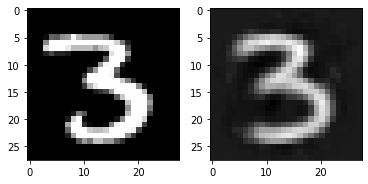

In [18]:
plot_image(12)

Time taken to decompress => 0.02045366000015747 secs


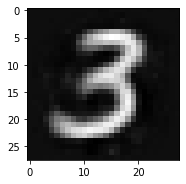

In [19]:
generate_image([encoded_images[215]])

In [29]:
#ae.save("models/mnist-numbers")
len(images[0].shape)


1